In [10]:
!pip install protobuf


[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: C:\Users\Lucia\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [13]:
!pip install mediapipe opencv-python

!pip install -q mediapipe


[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: C:\Users\Lucia\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: C:\Users\Lucia\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
!pip install pandas

In [4]:
import os
import cv2
import imghdr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import mediapipe as mp

      Class                     Image  Eye-Chin Proportion  \
0     angry  PrivateTest_10131363.jpg             1.093691   
1     angry  PrivateTest_12000629.jpg             1.327898   
2     angry  PrivateTest_12008383.jpg             2.198990   
3     angry  PrivateTest_12191716.jpg             1.716929   
4     angry   PrivateTest_1221822.jpg             1.716929   
...     ...                       ...                  ...   
3637    sad   PublicTest_99573433.jpg             1.268648   
3638    sad    PublicTest_9967827.jpg             0.760345   
3639    sad   PublicTest_99688200.jpg             1.402132   
3640    sad   PublicTest_99741160.jpg             0.870524   
3641    sad   PublicTest_99767171.jpg             1.343404   

      Mouth-Chin Proportion  
0                  1.082781  
1                  1.675617  
2                  0.493865  
3                  1.339447  
4                  0.750000  
...                     ...  
3637               1.493576  
3638           

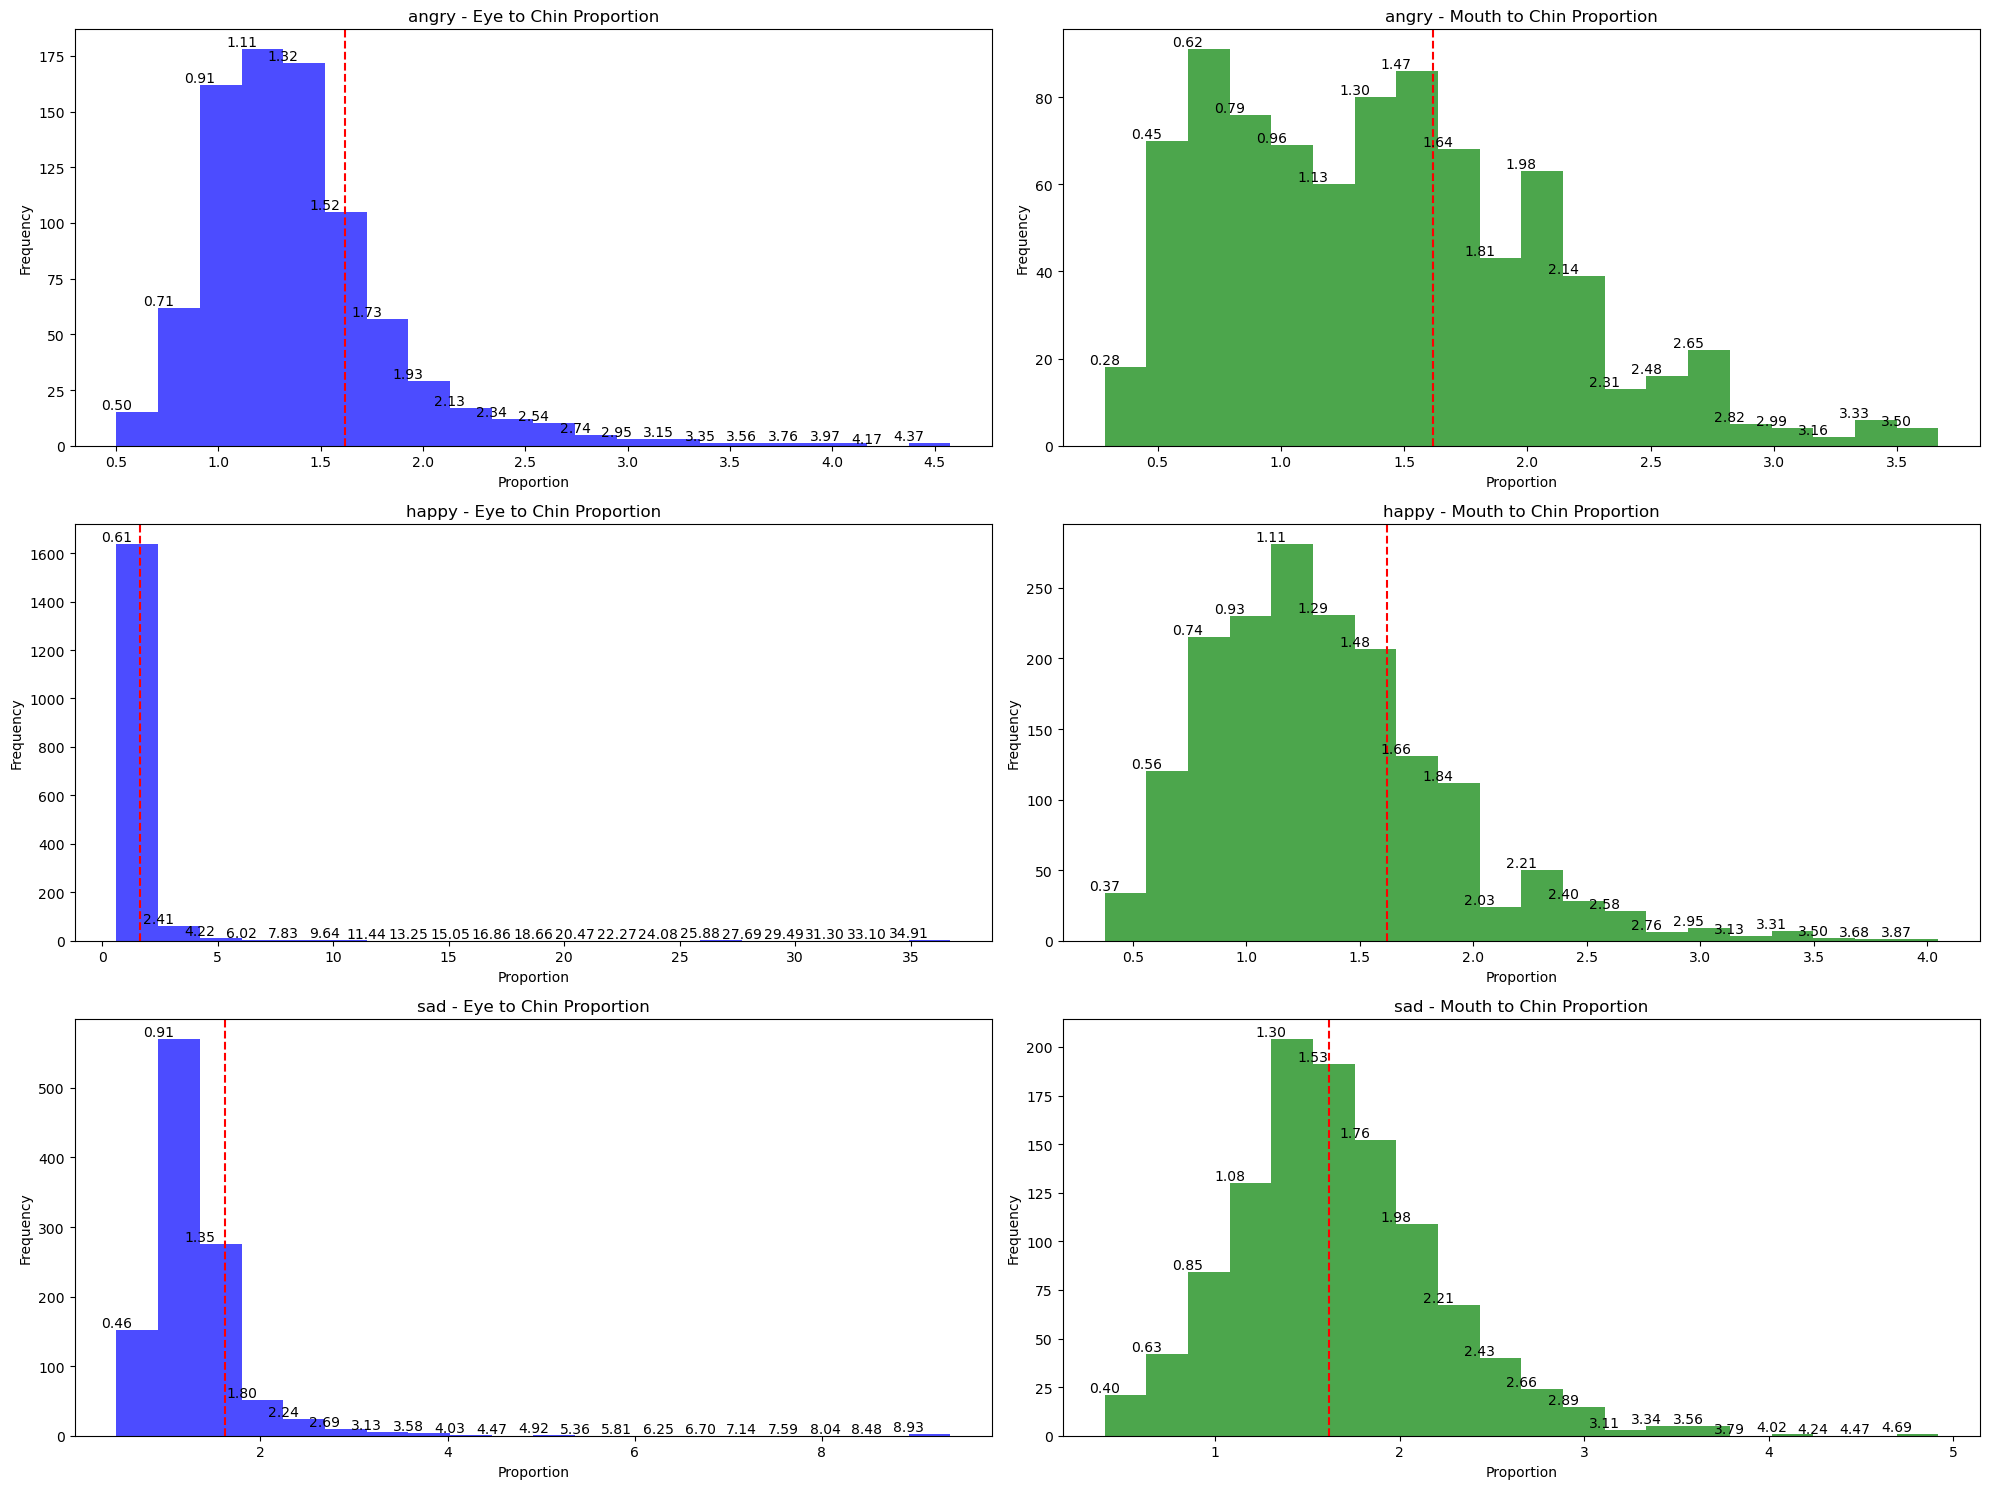

In [10]:
data_dir = 'Emotions'
image_exts = ['jpeg', 'jpg', 'png']
 
# Inicializar Mediapipe
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
 
# Función para calcular las proporciones áureas
def calculate_proportions(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error al cargar la imagen desde {image_path}. Verifica la ruta y asegúrate de que el archivo exista.")
        return None, None
 
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        min_detection_confidence=0.5) as face_mesh:
        results = face_mesh.process(image_rgb)
        if results.multi_face_landmarks is None:
            print(f"No se encontraron rostros en la imagen {image_path}")
            os.remove(image_path)
            return None, None
        for face_landmarks in results.multi_face_landmarks:
            landmarks = face_landmarks.landmark
            h, w, _ = image.shape
            points = [
                (landmarks[33].x * w, landmarks[33].y * h), # ojo izquierdo
                (landmarks[263].x * w, landmarks[263].y * h), # ojo izquierdo
                (landmarks[2].x * w, landmarks[2].y * h),     # Base Nariz 
                (landmarks[152].x * w, landmarks[152].y * h),  # Mentón
                (landmarks[0].x * w, landmarks[0].y * h),  # labio superior
                (landmarks[17].x * w, landmarks[17].y * h) # labio inferior
                
                
            ]
            points = [(int(x), int(y)) for x, y in points]
            x1, y1 = points[0]
            x2, y2 = points[1]
            x3, y3 = points[2]
            x4, y4 = points[3]
            x5, y5 = points[4]
            x6, y6 = points[5]
 
            # Punto medio entre los ojos
            x_mid = (x1 + x2) / 2
            y_mid = (y1 + y2) / 2

            eye_distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            eye_to_nose = abs(y3 - y_mid)
            nose_to_chin = np.sqrt((x4 - x3)**2 + (y4 - y3)**2)
            mouth_distance = np.sqrt((x6 - x5)**2 + (y6 - y5)**2)
            mouth_to_chin = np.sqrt((x6 - x4)**2 + (y6 - y4)**2)
 
            proportion_eye_chin = nose_to_chin/eye_to_nose
            proportion_mouth_chin = mouth_to_chin/mouth_distance
 
            return proportion_eye_chin, proportion_mouth_chin
    return None, None
 
# Diccionario para almacenar las proporciones por clase de imagen
proportions_by_class = {}
data = []

# Iterar sobre las imágenes y calcular proporciones
for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_dir):
        continue
    proportions_by_class[image_class] = {'eye_chin': [], 'mouth_chin': []}
    for image in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image)
        tip = imghdr.what(image_path)
        if tip not in image_exts:
            print(f'Image not in ext list {image_path}')
            os.remove(image_path)
            continue
        try:
            prop_eye_chin, prop_mouth_chin = calculate_proportions(image_path)
            if prop_eye_chin and prop_mouth_chin:
                proportions_by_class[image_class]['eye_chin'].append(prop_eye_chin)
                proportions_by_class[image_class]['mouth_chin'].append(prop_mouth_chin)
                data.append([image_class, image, prop_eye_chin, prop_mouth_chin])
        except Exception as e:
            print(f'Issue with image {image_path}: {e}')
            continue
 
# Crear DataFrame
df = pd.DataFrame(data, columns=['Class', 'Image', 'Eye-Chin Proportion', 'Mouth-Chin Proportion'])

# Imprimir DataFrame
print(df)

# Graficar las proporciones por clase de imagen
fig, ax = plt.subplots(nrows=len(proportions_by_class), ncols=2, figsize=(20, 5*len(proportions_by_class)))
 
for idx, (image_class, proportions) in enumerate(proportions_by_class.items()):
    # Graficar proporciones eye_chin
    counts, bins, patches = ax[idx, 0].hist(proportions['eye_chin'], bins=20, color='blue', alpha=0.7)
    ax[idx, 0].axvline(x=1.618, color='r', linestyle='--')
    ax[idx, 0].set_title(f'{image_class} - Eye to Chin Proportion')
    ax[idx, 0].set_xlabel('Proportion')
    ax[idx, 0].set_ylabel('Frequency')
    for count, bin in zip(counts, bins):
        ax[idx, 0].text(bin, count, f'{bin:.2f}', ha='center', va='bottom')

    # Graficar proporciones mouth_chin
    counts, bins, patches = ax[idx, 1].hist(proportions['mouth_chin'], bins=20, color='green', alpha=0.7)
    ax[idx, 1].axvline(x=1.618, color='r', linestyle='--')
    ax[idx, 1].set_title(f'{image_class} - Mouth to Chin Proportion')
    ax[idx, 1].set_xlabel('Proportion')
    ax[idx, 1].set_ylabel('Frequency')
    for count, bin in zip(counts, bins):
        ax[idx, 1].text(bin, count, f'{bin:.2f}', ha='center', va='bottom')
 
plt.tight_layout()
plt.show()
